##### Copyright 2020 The TensorFlow Authors.

In [ ]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Barren plateaus

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/quantum/tutorials/barren_plateaus"><img src="https://www.tensorflow.org/images/tf_logo_32px.png" />View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/quantum/blob/master/docs/tutorials/barren_plateaus.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/quantum/blob/master/docs/tutorials/barren_plateaus.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/quantum/docs/tutorials/barren_plateaus.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>

In this example you will explore the result of <a href="https://www.nature.com/articles/s41467-018-07090-4" class="external">McClean, 2019</a> that says not just any quantum neural network structure will do well when it comes to learning. In particular you will see that a certain large family of random quantum circuits do not serve as good quantum neural networks, because they have gradients that vanish almost everywhere. In this example you won't be training any models for a specific learning problem, but instead focusing on the simpler problem of understanding the behaviors of gradients.

## Setup

In [1]:
!pip install tensorflow==2.4.1

     |████████████████████████████████| 394.3 MB 13 kB/s 
     |████████████████████████████████| 132 kB 31.5 MB/s 
     |████████████████████████████████| 3.8 MB 32.0 MB/s 
     |████████████████████████████████| 462 kB 54.6 MB/s 
     |████████████████████████████████| 2.9 MB 46.0 MB/s 
  Created wheel for wrapt: filename=wrapt-1.12.1-cp37-cp37m-linux_x86_64.whl size=68720 sha256=ba8b422abb6eb327cb1183a7c869171c348746a51ed3faeb1c51e1e11137825f
  Stored in directory: /root/.cache/pip/wheels/62/76/4c/aa25851149f3f6d9785f6c869387ad82b3fd37582fa8147ac6
Successfully built wrapt
  Attempting uninstall: typing-extensions
    Found existing installation: typing-extensions 3.10.0.2
    Uninstalling typing-extensions-3.10.0.2:
      Successfully uninstalled typing-extensions-3.10.0.2
  Attempting uninstall: grpcio
    Found existing installation: grpcio 1.43.0
    Uninstalling grpcio-1.43.0:
      Successfully uninstalled grpcio-1.43.0
  Attempting uninstall: absl-py
    Found existing install

Install TensorFlow Quantum:

In [2]:
!pip install tensorflow-quantum

     |████████████████████████████████| 7.8 MB 3.8 MB/s 
     |████████████████████████████████| 90 kB 9.1 MB/s 
     |████████████████████████████████| 1.3 MB 71.9 MB/s 
     |████████████████████████████████| 5.6 MB 31.0 MB/s 
     |████████████████████████████████| 90 kB 8.8 MB/s 
     |████████████████████████████████| 100 kB 10.5 MB/s 
     |████████████████████████████████| 380 kB 48.4 MB/s 
     |████████████████████████████████| 1.5 MB 36.0 MB/s 
     |████████████████████████████████| 93 kB 918 kB/s 
     |████████████████████████████████| 93 kB 1.4 MB/s 
     |████████████████████████████████| 93 kB 1.1 MB/s 
     |████████████████████████████████| 93 kB 1.2 MB/s 
     |████████████████████████████████| 93 kB 560 kB/s 
     |████████████████████████████████| 93 kB 507 kB/s 
     |████████████████████████████████| 93 kB 739 kB/s 
     |████████████████████████████████| 93 kB 906 kB/s 
     |████████████████████████████████| 92 kB 617 kB/s 
     |███████████████████████████████

In [3]:
# Update package resources to account for version changes.
import importlib, pkg_resources
importlib.reload(pkg_resources)

<module 'pkg_resources' from '/usr/local/lib/python3.7/dist-packages/pkg_resources/__init__.py'>

Now import TensorFlow and the module dependencies:

In [4]:
import tensorflow as tf
import tensorflow_quantum as tfq

import cirq
import sympy
import numpy as np

# visualization tools
%matplotlib inline
import matplotlib.pyplot as plt
from cirq.contrib.svg import SVGCircuit

np.random.seed(1234)

## 1. Summary

Random quantum circuits with many blocks that look like this ($R_{P}(\theta)$ is a random Pauli rotation):<br/>
<img src="https://github.com/tensorflow/quantum/blob/master/docs/tutorials/images/barren_2.png?raw=1" width=700>

Where if $f(x)$ is defined as the expectation value w.r.t. $Z_{a}Z_{b}$ for any qubits $a$ and $b$, then there is a problem that $f'(x)$  has a mean very close to 0 and does not vary much. You will see this below:

## 2. Generating random circuits

The construction from the paper is straightforward to follow. The following implements a simple function that generates a random quantum circuit—sometimes referred to as a *quantum neural network* (QNN)—with the given depth on a set of qubits:

In [5]:
def generate_random_qnn(qubits, symbol, depth):
    """Generate random QNN's with the same structure from McClean et al."""
    circuit = cirq.Circuit()
    for qubit in qubits:
        circuit += cirq.ry(np.pi / 4.0)(qubit)

    for d in range(depth):
        # Add a series of single qubit rotations.
        for i, qubit in enumerate(qubits):
            random_n = np.random.uniform()
            random_rot = np.random.uniform(
            ) * 2.0 * np.pi if i != 0 or d != 0 else symbol
            if random_n > 2. / 3.:
                # Add a Z.
                circuit += cirq.rz(random_rot)(qubit)
            elif random_n > 1. / 3.:
                # Add a Y.
                circuit += cirq.ry(random_rot)(qubit)
            else:
                # Add a X.
                circuit += cirq.rx(random_rot)(qubit)

        # Add CZ ladder.
        for src, dest in zip(qubits, qubits[1:]):
            circuit += cirq.CZ(src, dest)

    return circuit


generate_random_qnn(cirq.GridQubit.rect(1, 3), sympy.Symbol('theta'), 2)

(0, 0): ───Ry(0.25π)───Rx(theta)────@───Rx(0.553π)────────────────@───────
                                    │                             │
(0, 1): ───Ry(0.25π)───Ry(0.875π)───@───@────────────Rz(1.92π)────@───@───
                                        │                             │
(0, 2): ───Ry(0.25π)───Rz(1.56π)────────@────────────Rz(0.716π)───────@───

The authors investigate the gradient of a single parameter $\theta_{1,1}$. Let's follow along by placing a `sympy.Symbol` in the circuit where $\theta_{1,1}$ would be. Since the authors do not analyze the statistics for any other symbols in the circuit, let's replace them with random values now instead of later.

## 3. Running the circuits

Generate a few of these circuits along with an observable to test the claim that the gradients don't vary much. First, generate a batch of random circuits. Choose a random *ZZ* observable and batch calculate the gradients and variance using TensorFlow Quantum.

### 3.1 Batch variance computation

Let's write a helper function that computes the variance of the gradient of a given observable over a batch of circuits:

In [6]:
def process_batch(circuits, symbol, op):
    """Compute the variance of a batch of expectations w.r.t. op on each circuit that 
    contains `symbol`. Note that this method sets up a new compute graph every time it is
    called so it isn't as performant as possible."""

    # Setup a simple layer to batch compute the expectation gradients.
    expectation = tfq.layers.Expectation()

    # Prep the inputs as tensors
    circuit_tensor = tfq.convert_to_tensor(circuits)
    values_tensor = tf.convert_to_tensor(
        np.random.uniform(0, 2 * np.pi, (n_circuits, 1)).astype(np.float32))

    # Use TensorFlow GradientTape to track gradients.
    with tf.GradientTape() as g:
        g.watch(values_tensor)
        forward = expectation(circuit_tensor,
                              operators=op,
                              symbol_names=[symbol],
                              symbol_values=values_tensor)

    # Return variance of gradients across all circuits.
    grads = g.gradient(forward, values_tensor)
    grad_var = tf.math.reduce_std(grads, axis=0)
    return grad_var.numpy()[0]

### 3.1 Set up and run

Choose the number of random circuits to generate along with their depth and the amount of qubits they should act on. Then plot the results.

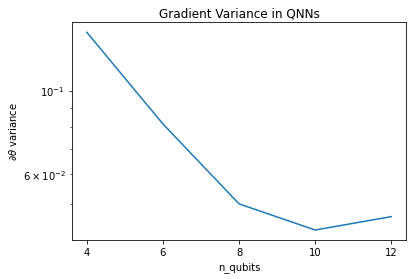

In [7]:
n_qubits = [2 * i for i in range(2, 7)
           ]  # Ranges studied in paper are between 2 and 24.
depth = 50  # Ranges studied in paper are between 50 and 500.
n_circuits = 200
theta_var = []

for n in n_qubits:
    # Generate the random circuits and observable for the given n.
    qubits = cirq.GridQubit.rect(1, n)
    symbol = sympy.Symbol('theta')
    circuits = [
        generate_random_qnn(qubits, symbol, depth) for _ in range(n_circuits)
    ]
    op = cirq.Z(qubits[0]) * cirq.Z(qubits[1])
    theta_var.append(process_batch(circuits, symbol, op))

plt.semilogy(n_qubits, theta_var)
plt.title('Gradient Variance in QNNs')
plt.xlabel('n_qubits')
plt.xticks(n_qubits)
plt.ylabel('$\\partial \\theta$ variance')
plt.show()

This plot shows that for quantum machine learning problems, you can't simply guess a random QNN ansatz and hope for the best. Some structure must be present in the model circuit in order for gradients to vary to the point where learning can happen.

## 4. Heuristics

An interesting heuristic by <a href="https://arxiv.org/pdf/1903.05076.pdf" class="external">Grant, 2019</a> allows one to start very close to random, but not quite. Using the same circuits as McClean et al., the authors propose a different initialization technique for the classical control parameters to avoid barren plateaus. The initialization technique starts some layers with totally random control parameters—but, in the layers immediately following, choose parameters such that the initial transformation made by the first few layers is undone. The authors call this an *identity block*.

The advantage of this heuristic is that by changing just a single parameter, all other blocks outside of the current block will remain the identity—and the gradient signal comes through much stronger than before. This allows the user to pick and choose which variables and blocks to modify to get a strong gradient signal. This heuristic does not prevent the user from falling in to a barren plateau during the training phase (and restricts a fully simultaneous update), it just guarantees that you can start outside of a plateau.

### 4.1 New QNN construction

Now construct a function to generate identity block QNNs. This implementation is slightly different than the one from the paper. For now, look at the behavior of the gradient of a single parameter so it is consistent with McClean et al, so some simplifications can be made.

To generate an identity block and train the model, generally you need $U1(\theta_{1a}) U1(\theta_{1b})^{\dagger}$ and not $U1(\theta_1) U1(\theta_1)^{\dagger}$. Initially $\theta_{1a}$ and $\theta_{1b}$ are the same angles but they are learned independently. Otherwise, you will always get the identity even after training. The choice for the number of identity blocks is empirical. The deeper the block, the smaller the variance in the middle of the block. But at the start and end of the block, the variance of the parameter gradients should be large. 

In [8]:
def generate_identity_qnn(qubits, symbol, block_depth, total_depth):
    """Generate random QNN's with the same structure from Grant et al."""
    circuit = cirq.Circuit()

    # Generate initial block with symbol.
    prep_and_U = generate_random_qnn(qubits, symbol, block_depth)
    circuit += prep_and_U

    # Generate dagger of initial block without symbol.
    U_dagger = (prep_and_U[1:])**-1
    circuit += cirq.resolve_parameters(
        U_dagger, param_resolver={symbol: np.random.uniform() * 2 * np.pi})

    for d in range(total_depth - 1):
        # Get a random QNN.
        prep_and_U_circuit = generate_random_qnn(
            qubits,
            np.random.uniform() * 2 * np.pi, block_depth)

        # Remove the state-prep component
        U_circuit = prep_and_U_circuit[1:]

        # Add U
        circuit += U_circuit

        # Add U^dagger
        circuit += U_circuit**-1

    return circuit


generate_identity_qnn(cirq.GridQubit.rect(1, 3), sympy.Symbol('theta'), 2, 2)

(0, 0): ───Ry(0.25π)───Rx(theta)────@───Rx(0.716π)────────────────@───────────@─────────────────Rx(-0.716π)───@───Rx(-1.62π)────Ry(1.15π)───@───Rz(1.7π)────────────────@───────────@─────────────────Rz(-1.7π)───@───Ry(-1.15π)───
                                    │                             │           │                               │                             │                           │           │                             │
(0, 1): ───Ry(0.25π)───Rz(0.356π)───@───@────────────Rz(0.153π)───@───@───@───@───Rz(-0.153π)───@─────────────@───Rz(-0.356π)───Rz(1.25π)───@───@──────────Rz(0.736π)───@───@───@───@───Rz(-0.736π)───@───────────@───Rz(-1.25π)───
                                        │                             │   │                     │                                               │                           │   │                     │
(0, 2): ───Ry(0.25π)───Rx(0.104π)───────@────────────Ry(0.792π)───────@───@───────Ry(-0.792π)───@─────────────────Rx(-0.104π)───Rz(1.46π)───────@──────────Rz(1.73π)────────@───@───────Rz(-1.73π)────@───────────────Rz(-1.46π)───

### 4.2 Comparison

Here you can see that the heuristic does help to keep the variance of the gradient from vanishing as quickly:

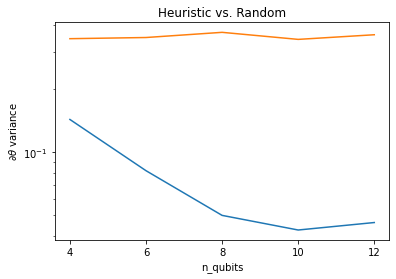

In [9]:
block_depth = 10
total_depth = 5

heuristic_theta_var = []

for n in n_qubits:
    # Generate the identity block circuits and observable for the given n.
    qubits = cirq.GridQubit.rect(1, n)
    symbol = sympy.Symbol('theta')
    circuits = [
        generate_identity_qnn(qubits, symbol, block_depth, total_depth)
        for _ in range(n_circuits)
    ]
    op = cirq.Z(qubits[0]) * cirq.Z(qubits[1])
    heuristic_theta_var.append(process_batch(circuits, symbol, op))

plt.semilogy(n_qubits, theta_var)
plt.semilogy(n_qubits, heuristic_theta_var)
plt.title('Heuristic vs. Random')
plt.xlabel('n_qubits')
plt.xticks(n_qubits)
plt.ylabel('$\\partial \\theta$ variance')
plt.show()

This is a great improvement in getting stronger gradient signals from (near) random QNNs.